In [19]:
!pip install kornia
!pip install kornia_rs

DEPRECATION: Loading egg at /home/philipp/miniforge3/envs/main/lib/python3.11/site-packages/pip-23.3.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/philipp/miniforge3/envs/main/lib/python3.11/site-packages/taichi-1.6.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/philipp/miniforge3/envs/main/lib/python3.11/site-packages/astra_toolbox-2.1.3-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/philipp/min

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import fusion_utils as utils
from tqdm import tqdm 
import numpy as np
import h5py
import kornia as K
import matplotlib.pyplot as plt
import torch
import torchvision


In [47]:
fname = 'CoSX_maps.h5'; mapNum = 'map7/'

# Parse Chemical Maps
elementList = ['Co', 'O', 'S']

# Load Raw Data and Reshape
file = h5py.File(fname, 'r')

print('Available EDX Maps: ', list(file))

xx =[]
for ee in elementList:

	# Read Chemical Map for Element "ee"
	edsMap = file[mapNum+ee][:,:]
    # print(edsMap.shape)
	# Set Noise Floor to Zero and Normalize Chemical Maps
	edsMap -= np.min(edsMap); edsMap /= np.max(edsMap)

	# Concatenate Chemical Map to Variable of Interest
	xx += [edsMap,]

# Make Copy of Raw Measurements for Poisson Maximum Likelihood Term 
EDX_images = np.array(xx)
EDX_images.shape

Available EDX Maps:  ['map4', 'map5', 'map6', 'map7', 'map8', 'map9']


(3, 512, 512)

In [48]:
def imshow(input: torch.Tensor):
    out = torchvision.utils.make_grid(input, nrow=2, padding=5)
    out_np = K.utils.tensor_to_image(out)
    plt.imshow(out_np)
    plt.axis("off")
    plt.show()

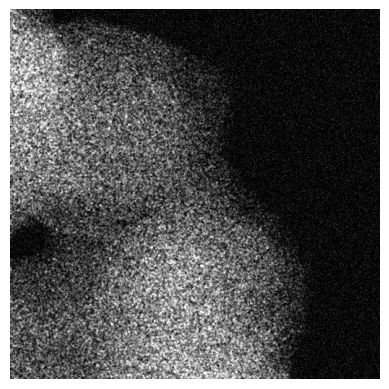

In [49]:
img = torch.as_tensor(EDX_images[0])

noisy_image = (img + torch.normal(torch.zeros_like(img), 0.1)).clamp(0, 1)
imshow(noisy_image)

# Denoise image using total variation


In [53]:
# define the total variation denoising network
class TVDenoise(torch.nn.Module):
    def __init__(self, noisy_image, l0 = 1.0, l1 = 2e-4):
        super().__init__()
        self.l0 = l0
        self.l1 = l1 
        self.l2_term = torch.nn.MSELoss(reduction="mean")
        # 
        self.regularization_term = K.losses.TotalVariation()
        # create the variable which will be optimized to produce the noise free image        
        self.clean_image = torch.nn.Parameter(data=noisy_image.clone(), requires_grad=True)
        self.noisy_image = noisy_image

    def forward(self):
        return self.l0 * self.l2_term(self.clean_image, self.noisy_image) + self.l1 * self.regularization_term(self.clean_image)

    def get_clean_image(self):
        return self.clean_image




In [61]:
tv_denoiser = TVDenoise(noisy_image, l0 = 1.0, l1 = 7e-4)
# define the optimizer to optimize the 1 parameter of tv_denoiser
optimizer = torch.optim.SGD(tv_denoiser.parameters(), lr=0.1, momentum=0.9)
num_iters: int = 500
for i in range(num_iters):
    optimizer.zero_grad()
    loss = tv_denoiser().sum()
    if i % 100 == 0:
        print(f"Loss in iteration {i} of {num_iters}: {loss.item():.3f}")
    loss.backward()
    optimizer.step()

Loss in iteration 0 of 500: 40.400
Loss in iteration 100 of 500: 8.819
Loss in iteration 200 of 500: 3.197
Loss in iteration 300 of 500: 1.441
Loss in iteration 400 of 500: 0.815


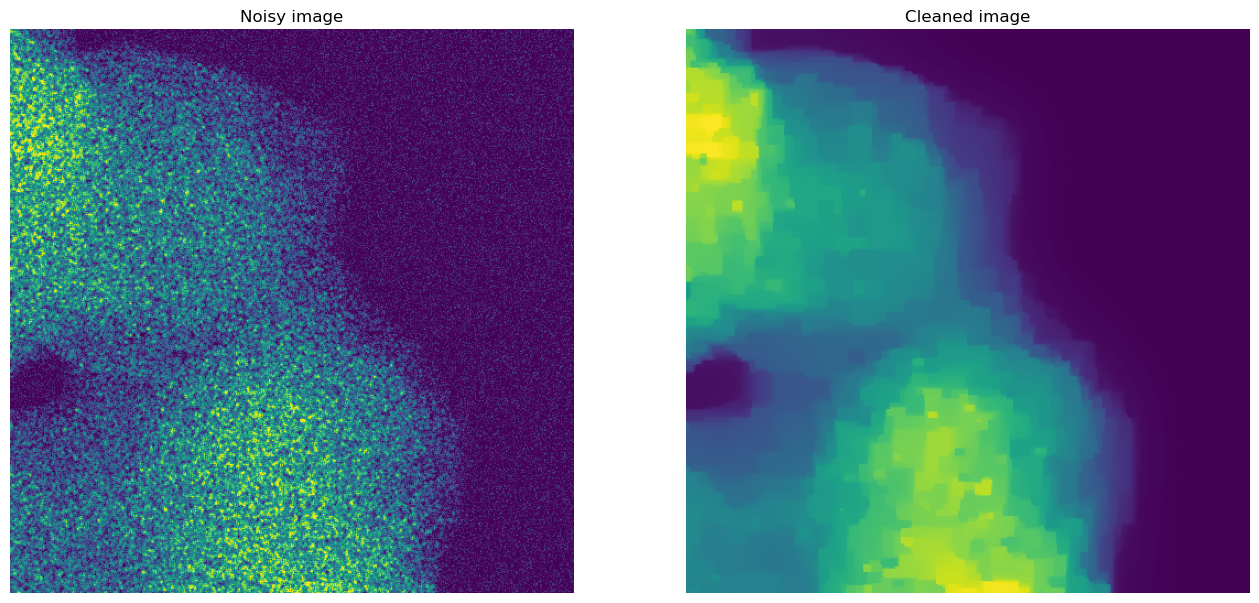

In [62]:
img_clean = K.utils.tensor_to_image(tv_denoiser.get_clean_image())

# Create the plot
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs = axs.ravel()
axs[0].axis("off")
axs[0].set_title("Noisy image")
axs[0].imshow(K.tensor_to_image(noisy_image))
axs[1].axis("off")
axs[1].set_title("Cleaned image")
axs[1].imshow(img_clean)
plt.show()

In [63]:
HAADF_image = file[mapNum+'HAADF'][:] 

# Data Subtraction and Normalization 
HAADF_image -= np.min(HAADF_image); HAADF_image /= np.max(HAADF_image)
(nx, ny) = edsMap.shape

In [64]:
EDX_images.shape

(3, 512, 512)

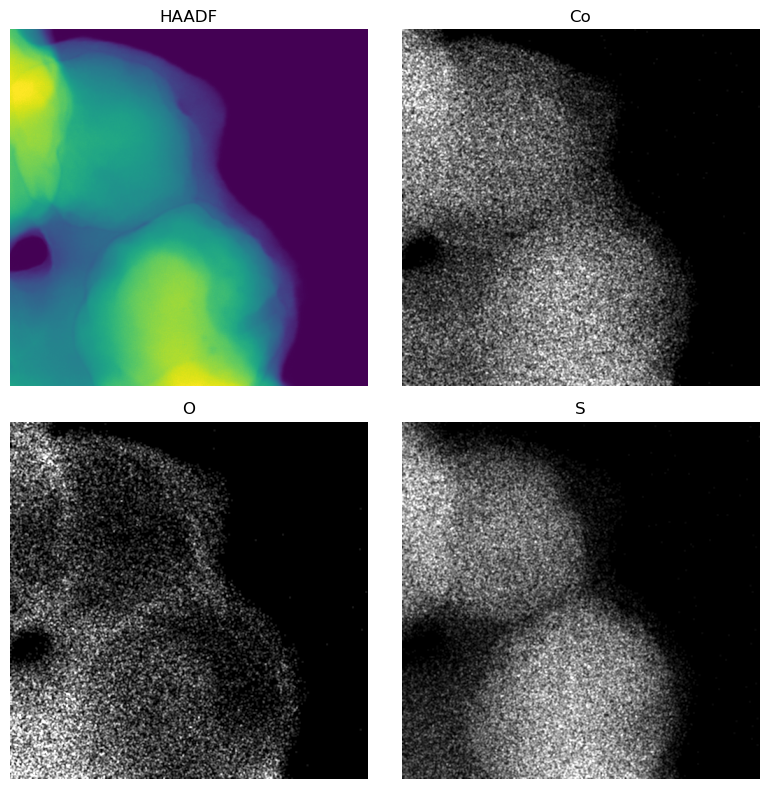

In [65]:
def plot_elemental_images(data,haadf,eList,nrows,ncols):

	fig, ax = plt.subplots(nrows,ncols,figsize=(8,8))
	ax = ax.flatten()

	ax[0].imshow(haadf.reshape(nx,ny)); ax[0].set_title('HAADF'); ax[0].axis('off')
	for ii in range(len(eList)):
		ax[ii+1].imshow(data[ii:(ii+1)].reshape(nx,ny),cmap='gray'); ax[ii+1].set_title(eList[ii]); ax[ii+1].axis('off')
	plt.tight_layout()
	plt.show()
plot_elemental_images(EDX_images, HAADF_image, elementList,2,2)

# The Sensor Fusion optimization problem

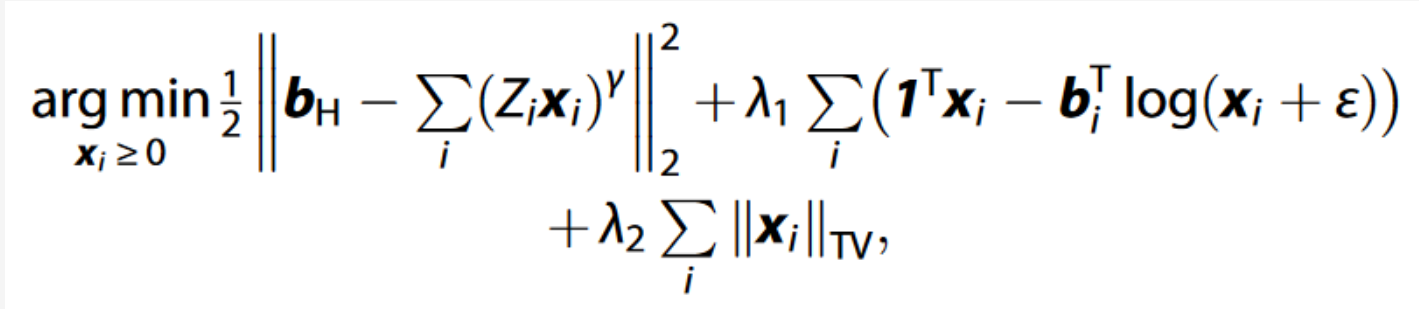
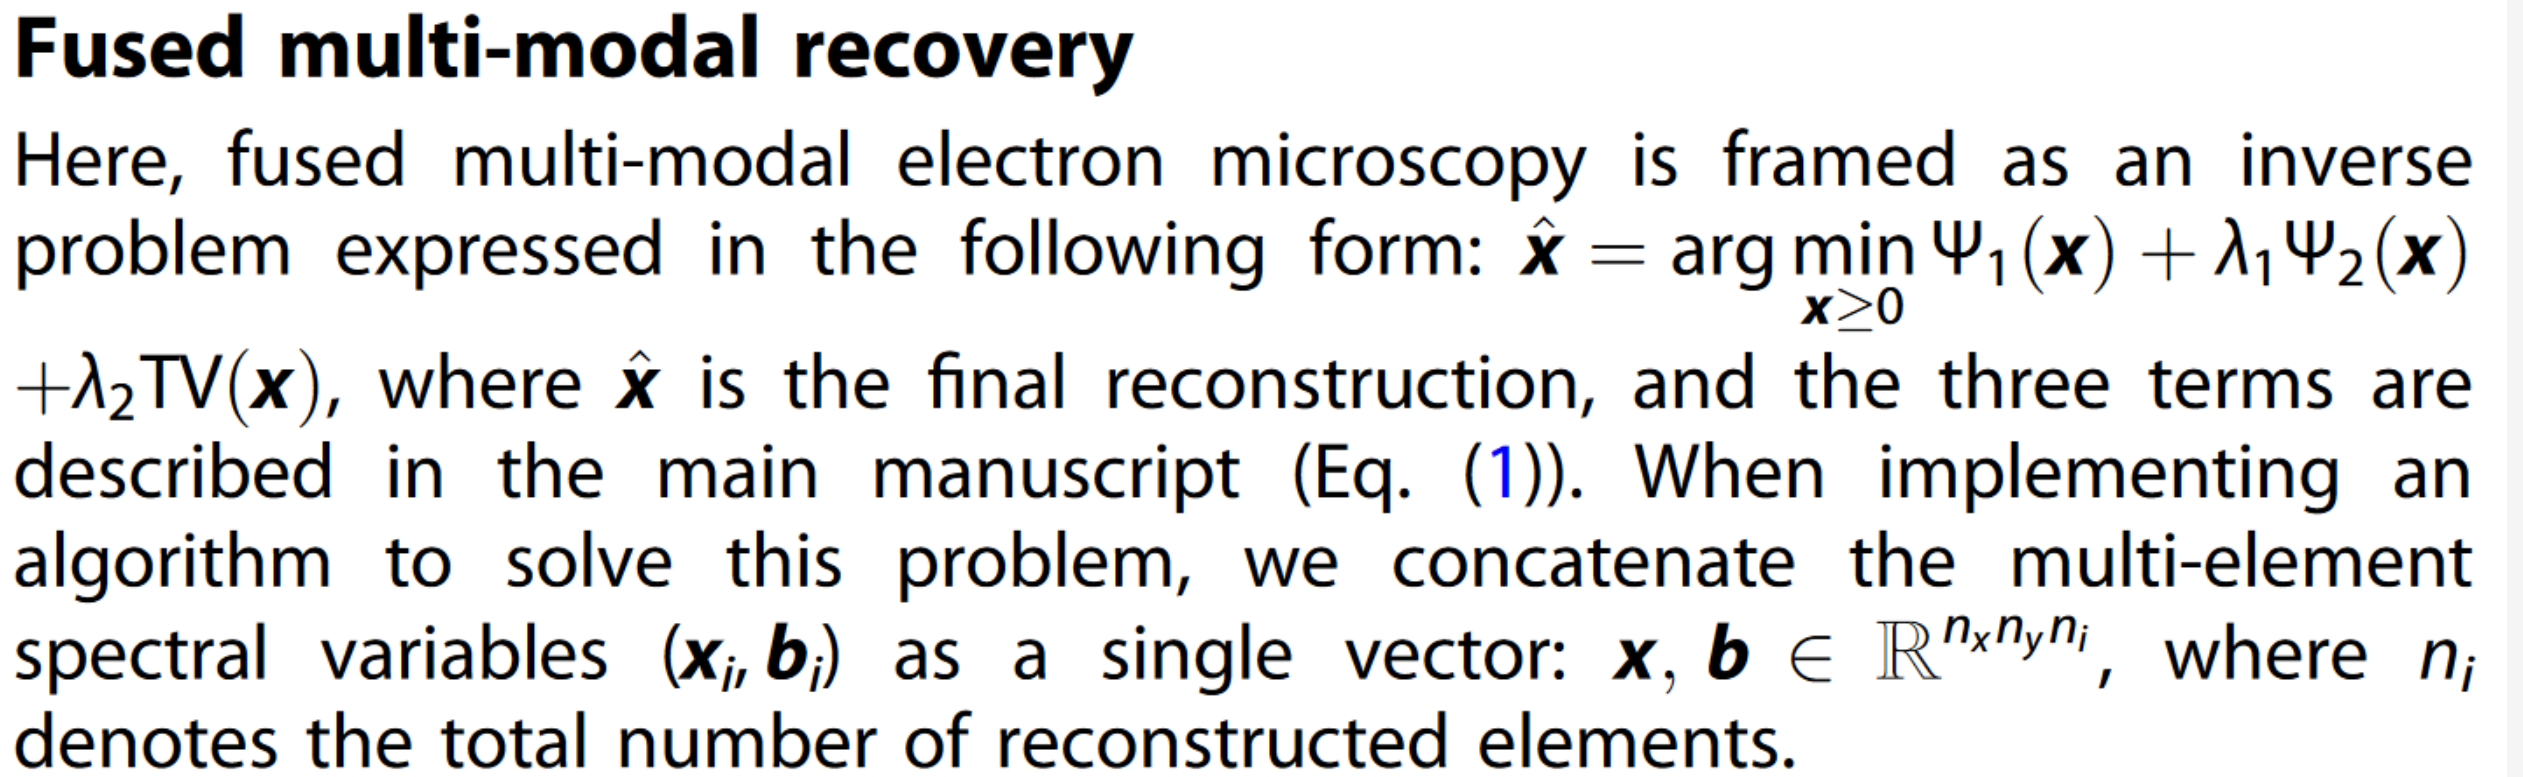


In [133]:
from torch.nn import PoissonNLLLoss

class SensorFusion(torch.nn.Module):
    def __init__(self, HAADF, EDX, l0 = 0.3, l1 = 2e-4, l2=5e-6, gamma=1.6):
        super().__init__()
        self.l0 = l0
        self.l1 = l1 
        self.l2 = l2
        self.gamma = gamma 
        self.l2_term = torch.nn.MSELoss(reduction="mean")
        self.poission_term = PoissonNLLLoss(reduction="mean", eps=1e-1)
        self.regularization_term = K.losses.TotalVariation()
        # create the variable which will be optimized to produce the noise free image        
        self.clean_EDX_images = torch.nn.Parameter(data=EDX.clone(), requires_grad=True)
        self.noisy_EDX_images = EDX
        self.HAADF = HAADF

    def forward(self):
        sum_term = torch.sum(self.clean_EDX_images**self.gamma,0)   
        w0 = self.l0 * self.l2_term(sum_term, self.HAADF)
        w1 = 0
        # for EDX_i in self.clean_EDX_images:
        #     w1 += self.l1 * self.regularization_term(EDX_i)
        w2 = self.l2 * self.poission_term(self.clean_EDX_images, self.noisy_EDX_images)
        return w0, w1, w2

    def get_clean_image(self):
        return self.clean_image

In [135]:
EDX_images = torch.as_tensor(EDX_images)
HAADF_image = torch.as_tensor(HAADF_image)
# tv_denoiser = SensorFusion(HAADF_image, EDX_images, l0 = 0.3, l1 = 2e-4, l2=5e-6, gamma=1.6)
sensor_fuse = SensorFusion(HAADF_image, EDX_images, l0 = 30, l1 = 1e-5, l2=0, gamma=1.6)
# define the optimizer to optimize the 1 parameter of tv_denoiser
optimizer = torch.optim.SGD(sensor_fuse.parameters(), lr=1, momentum=0.9)
num_iters: int = 500
for i in range(num_iters):
    optimizer.zero_grad()    
    w0, w1, w2 = sensor_fuse()    
    
    loss = w0 + w1 + w2  
    if i % 20 == 0:
        print(f"Loss in iteration {i} of {num_iters}: {loss.item():.3f} {w0.item():.3f} {w1.item():.3f} {w2.item():.3f}")
    loss.backward()
    optimizer.step()

Loss in iteration 0 of 500: 2.227 1.395 0.832 0.000
Loss in iteration 20 of 500: nan nan nan nan
Loss in iteration 40 of 500: nan nan nan nan
Loss in iteration 60 of 500: nan nan nan nan
Loss in iteration 80 of 500: nan nan nan nan
Loss in iteration 100 of 500: nan nan nan nan
Loss in iteration 120 of 500: nan nan nan nan
Loss in iteration 140 of 500: nan nan nan nan
Loss in iteration 160 of 500: nan nan nan nan
Loss in iteration 180 of 500: nan nan nan nan


KeyboardInterrupt: 

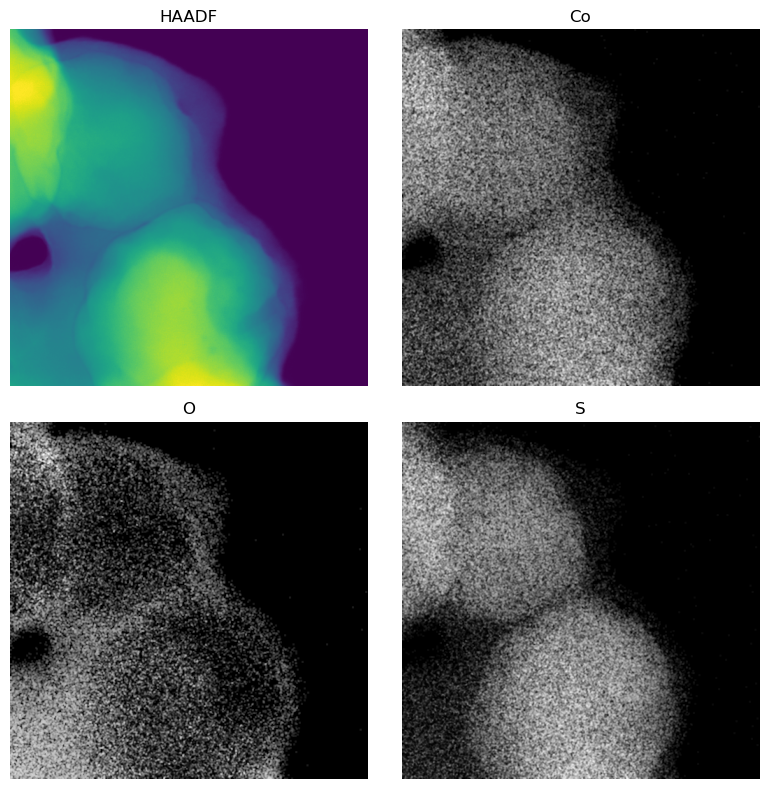

In [125]:
plot_elemental_images(sensor_fuse.clean_EDX_images.detach().numpy(), HAADF_image, elementList,2,2)

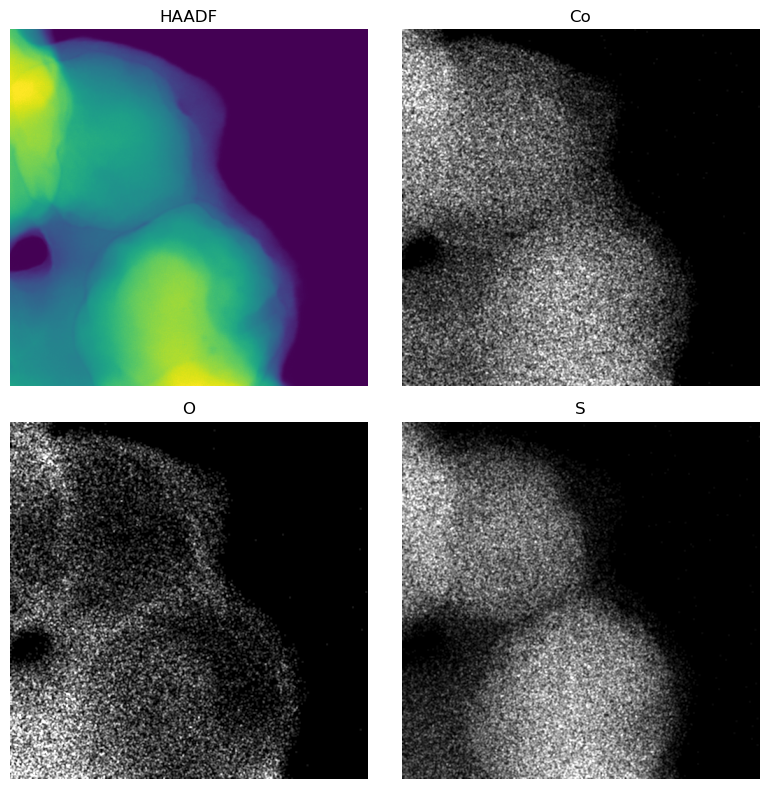

In [126]:
plot_elemental_images(sensor_fuse.noisy_EDX_images.detach().numpy(), HAADF_image, elementList,2,2)